In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=439134d7557c7794c8db99f29b8dcc988086605d540199da30a70e60739879cd
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Text Summarizer with spAcy word vector sentence embeddings + KMeans Clustering with Visualization and Evaluation Metrics(ROUGE)**

In [ ]:
import re
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from rouge_score import rouge_scorer


In [ ]:
#Preprocessing
custom_stop_words = {"the", "in", "on", "of", "and", "a", "an"}

def selective_lowercase(text):
    tokens = text.split()
    processed_tokens = []
    for token in tokens:
        token_core = re.sub(r'^\W+|\W+$', '', token)
        if (token_core.isupper() and len(token_core) > 1) or re.search(r'\d', token_core):
            processed_tokens.append(token)
        else:
            processed_tokens.append(token.lower())
    return " ".join(processed_tokens)

def selective_stopword_removal(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token.lower() not in custom_stop_words]
    return " ".join(filtered_tokens)

def preprocess_sentence(sentence):
    sentence = selective_lowercase(sentence)
    return selective_stopword_removal(sentence)


In [ ]:
# --- Sample Sentences ---
sentences = [
    "The Expanded Programme on Immunisation was launched by the WHO in 1974.",
    "Smallpox was declared eradicated in 1980 after a successful global vaccination campaign.",
    "The climate crisis is spurring disease outbreaks in vulnerable communities.",
    "The UK is considering a significant cut to its support for global vaccine programs.",
    "Polio remains endemic in just a few countries, but progress is steady."
]



In [ ]:
# Preprocess sentences
preprocessed_sentences = [preprocess_sentence(sent) for sent in sentences]

# Embedding Setup
nlp = spacy.load("en_core_web_md")

def get_sentence_embedding(sentence):
    doc = nlp(sentence)
    word_vectors = [token.vector for token in doc if token.has_vector and not token.is_stop]
    return np.mean(word_vectors, axis=0) if word_vectors else doc.vector

# Get sentence embeddings
sentence_embeddings = np.array([get_sentence_embedding(sent) for sent in preprocessed_sentences])

In [ ]:
# --- KMeans Summarization ---
def kmeans_summarization(original_sentences, embeddings, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    selected_sentences = []
    for i in range(n_clusters):
        cluster_indices = [j for j, label in enumerate(cluster_labels) if label == i]
        closest_idx = min(cluster_indices, key=lambda idx: np.linalg.norm(embeddings[idx] - cluster_centers[i]))
        selected_sentences.append((closest_idx, original_sentences[closest_idx]))

    selected_sentences.sort(key=lambda x: x[0])
    return " ".join(sent for _, sent in selected_sentences), cluster_labels

# Generate summary and cluster labels
generated_summary, cluster_labels = kmeans_summarization(sentences, sentence_embeddings, n_clusters=3)



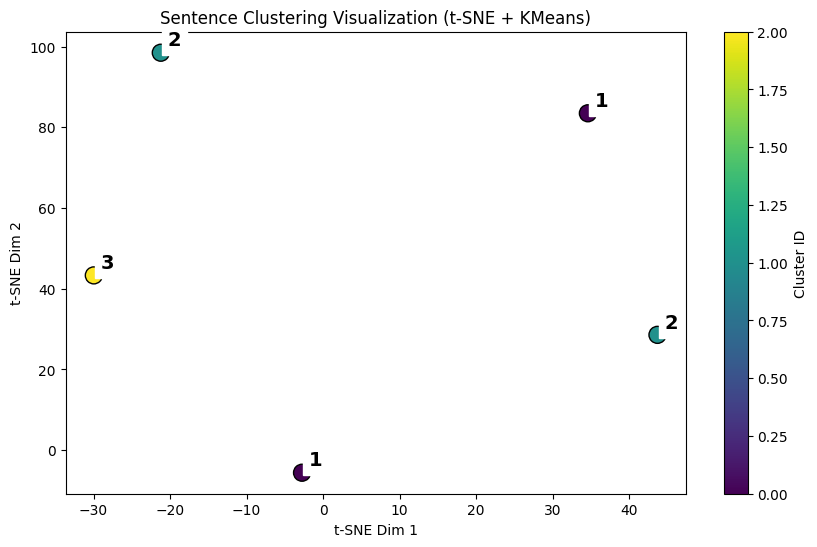


Cluster Assignments:
Cluster 2: The Expanded Programme on Immunisation was launched by the WHO in 1974.
Cluster 2: Smallpox was declared eradicated in 1980 after a successful global vaccination campaign.
Cluster 1: The climate crisis is spurring disease outbreaks in vulnerable communities.
Cluster 3: The UK is considering a significant cut to its support for global vaccine programs.
Cluster 1: Polio remains endemic in just a few countries, but progress is steady.


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- t-SNE Visualization ---
def visualize_clusters(embeddings, cluster_labels, sentences):
    n_samples = len(embeddings)
    perplexity = min(5, n_samples - 1)  # Ensure perplexity is less than the number of samples

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        reduced_embeddings[:, 0], reduced_embeddings[:, 1],
        c=cluster_labels, cmap='viridis', s=150, edgecolors='black'  # Larger points, darker edges
    )
    plt.colorbar(scatter, label="Cluster ID")

    for i in range(len(embeddings)):
        plt.annotate(
            str(cluster_labels[i] + 1),  # Offset by +1
            (reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
            fontsize=14, weight="bold", color="black", backgroundcolor="white",
            xytext=(5, 5), textcoords="offset points"  # Better placement
        )

    plt.title("Sentence Clustering Visualization (t-SNE + KMeans)")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()

    # --- Print cluster assignments ---
    print("\nCluster Assignments:")
    for i, sentence in enumerate(sentences):
        print(f"Cluster {cluster_labels[i] + 1}: {sentence}")

# Show visualization
visualize_clusters(sentence_embeddings, cluster_labels, sentences)


In [ ]:
# --- ROUGE Comparison ---
provided_summary = (
    "Global immunization initiatives have achieved notable milestones, including the WHO’s launch "
    "of the Expanded Programme on Immunisation in 1974 and the eradication of smallpox in 1980. "
    "However, emerging challenges—such as disease outbreaks fueled by the climate crisis and potential funding cuts, "
    "as seen in the UK—highlight ongoing vulnerabilities. Meanwhile, steady progress continues against polio, even though "
    "it remains endemic in a few countries."
)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(provided_summary, generated_summary)

# --- Display Results ---
print("Generated Summary:")
print(generated_summary)
print("\nROUGE Scores:")
for key, value in scores.items():
    print(f"{key}: {value}")

Generated Summary:
The Expanded Programme on Immunisation was launched by the WHO in 1974. The climate crisis is spurring disease outbreaks in vulnerable communities. The UK is considering a significant cut to its support for global vaccine programs.

ROUGE Scores:
rouge1: Score(precision=0.6388888888888888, recall=0.3484848484848485, fmeasure=0.45098039215686275)
rouge2: Score(precision=0.3142857142857143, recall=0.16923076923076924, fmeasure=0.22)
rougeL: Score(precision=0.3888888888888889, recall=0.21212121212121213, fmeasure=0.27450980392156865)


**Text Summarizer with SBERT sentence embeddings + KMeans Clustering with Visualization and Evaluation Metrics(ROUGE)**

In [ ]:

from sentence_transformers import SentenceTransformer

In [ ]:
# Preprocess sentences
preprocessed_sentences = [preprocess_sentence(sent) for sent in sentences]

# --- SBERT Embedding Setup ---
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
def get_sentence_embedding(sentence):
    return sbert_model.encode(sentence)

# Get sentence embeddings
sentence_embeddings = np.array([get_sentence_embedding(sent) for sent in preprocessed_sentences])

In [ ]:
# --- KMeans Summarization ---
def kmeans_summarization(original_sentences, embeddings, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    selected_sentences = []
    for i in range(n_clusters):
        cluster_indices = [j for j, label in enumerate(cluster_labels) if label == i]
        closest_idx = min(cluster_indices, key=lambda idx: np.linalg.norm(embeddings[idx] - cluster_centers[i]))
        selected_sentences.append((closest_idx, original_sentences[closest_idx]))

    selected_sentences.sort(key=lambda x: x[0])
    return " ".join(sent for _, sent in selected_sentences), cluster_labels

# Generate summary and cluster labels
generated_summary, cluster_labels = kmeans_summarization(sentences, sentence_embeddings, n_clusters=3)

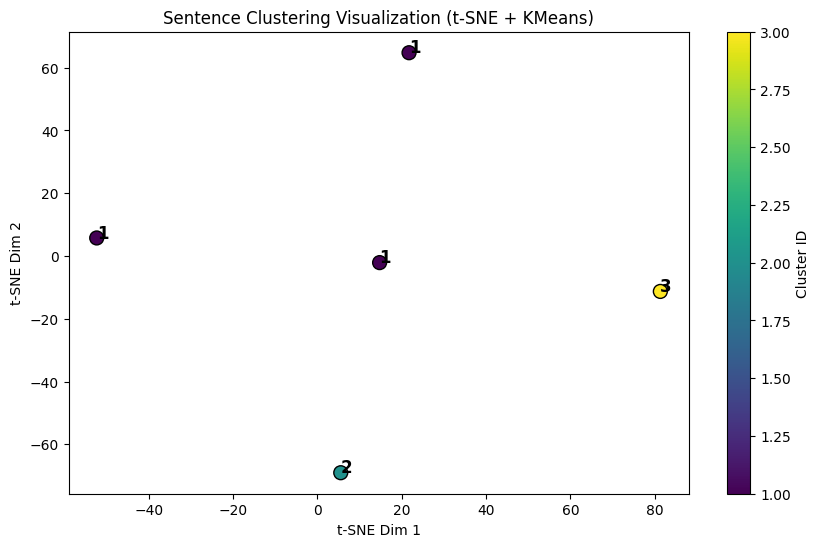


Cluster Assignments:
Cluster 1: The Expanded Programme on Immunisation was launched by the WHO in 1974.
Cluster 1: Smallpox was declared eradicated in 1980 after a successful global vaccination campaign.
Cluster 2: The climate crisis is spurring disease outbreaks in vulnerable communities.
Cluster 1: The UK is considering a significant cut to its support for global vaccine programs.
Cluster 3: Polio remains endemic in just a few countries, but progress is steady.


In [ ]:
def visualize_clusters(embeddings, cluster_labels, sentences):
    perplexity = min(5, len(embeddings) - 1)  # Ensure valid perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Adjust cluster labels to start from 1 instead of 0
    adjusted_labels = [label + 1 for label in cluster_labels]

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                          c=adjusted_labels, cmap='viridis', s=100, edgecolors='k')
    plt.colorbar(scatter, label="Cluster ID")

    # Only show cluster numbers in the plot
    for i, cluster in enumerate(adjusted_labels):
        plt.annotate(str(cluster), (reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                     fontsize=12, fontweight='bold')

    plt.title("Sentence Clustering Visualization (t-SNE + KMeans)")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()

    # Print sentence-cluster mapping
    print("\nCluster Assignments:")
    for i, sentence in enumerate(sentences):
        print(f"Cluster {adjusted_labels[i]}: {sentence}")

# Show visualization
visualize_clusters(sentence_embeddings, cluster_labels, sentences)


In [ ]:
provided_summary = (
    "Global immunization initiatives have achieved notable milestones, including the WHO’s launch "
    "of the Expanded Programme on Immunisation in 1974 and the eradication of smallpox in 1980. "
    "However, emerging challenges—such as disease outbreaks fueled by the climate crisis and potential funding cuts, "
    "as seen in the UK—highlight ongoing vulnerabilities. Meanwhile, steady progress continues against polio, even though "
    "it remains endemic in a few countries."
)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(provided_summary, generated_summary)

# --- Display Results ---
print("Generated Summary:")
print(generated_summary)
print("\nROUGE Scores:")
for key, value in scores.items():
    print(f"{key}: {value}")

Generated Summary:
The Expanded Programme on Immunisation was launched by the WHO in 1974. The climate crisis is spurring disease outbreaks in vulnerable communities. Polio remains endemic in just a few countries, but progress is steady.

ROUGE Scores:
rouge1: Score(precision=0.7941176470588235, recall=0.4090909090909091, fmeasure=0.54)
rouge2: Score(precision=0.42424242424242425, recall=0.2153846153846154, fmeasure=0.28571428571428575)
rougeL: Score(precision=0.5588235294117647, recall=0.2878787878787879, fmeasure=0.38000000000000006)


In [ ]:
!pip install numpy nltk sklearn networkx rouge-score


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


**Multiple Document Summarization using a hybrid approach : LSA+TextRank(for abstractive summary generation)+Evaluation metrics (ROUGE)**

In [ ]:
import numpy as np
import networkx as nx
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
src_1 = [
    "The Expanded Programme on Immunisation was launched by the WHO in 1974.",
    "Smallpox was declared eradicated in 1980 after a successful global vaccination campaign.",
    "The climate crisis is spurring disease outbreaks in vulnerable communities.",
    "The UK is considering a significant cut to its support for global vaccine programs.",
    "Polio remains endemic in just a few countries, but progress is steady."
]

src_2 = [
    "Vaccination efforts have drastically reduced child mortality rates worldwide.",
    "WHO's immunization programs have saved millions of lives over the past decades.",
    "Emerging diseases demand faster vaccine development and equitable distribution.",
    "Public-private partnerships have played a crucial role in making vaccines accessible.",
    "Investment in vaccine infrastructure is key to preventing future pandemics."
]

src_3 = [
    "Low-income countries rely heavily on international vaccine initiatives for immunization.",
    "The cost of vaccine development has been offset by global funding strategies.",
    "Gavi has supported immunization programs in over 70 countries, improving access.",
    "Political instability affects vaccine distribution in conflict zones.",
    "Researchers are working on next-generation vaccines to combat evolving viruses."
]


In [ ]:
# Manually written base summary
base_summary = """The WHO’s Expanded Programme on Immunisation, launched in 1974, has led to significant milestones,
including the eradication of smallpox in 1980. However, new challenges arise as the climate crisis accelerates disease
outbreaks and global vaccine funding faces potential cuts. Despite progress in reducing child mortality and combating
diseases like polio, continued efforts are crucial. Public-private partnerships and global initiatives like Gavi play
a key role in making vaccines accessible, especially in low-income nations. Meanwhile, political instability and evolving
viruses threaten distribution, emphasizing the need for next-generation vaccines and stronger infrastructure investments
to prevent future pandemics."""

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def lsa_summarization(sentences, num_sentences=3):
    if len(sentences) == 0:
        return "No summary: Input text is empty."

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    # Ensure the number of components doesn't exceed available sentences
    n_components = min(X.shape[0] - 1, X.shape[1], 1)  # SVD requires (n_samples > n_components)

    if n_components <= 0:
        return "Not enough data for summarization."

    svd = TruncatedSVD(n_components=n_components)
    X_reduced = svd.fit_transform(X)

    # Compute sentence scores using LSA
    scores = np.argsort(-X_reduced[:, 0])  # Sort in descending order

    # Prevent out-of-range errors
    selected_sentences = min(num_sentences, len(sentences))
    summary = [sentences[i] for i in scores[:selected_sentences]]

    return " ".join(summary)


In [ ]:
lsa_summary_1 = lsa_summarization(src_1)
lsa_summary_2 = lsa_summarization(src_2)
lsa_summary_3 = lsa_summarization(src_3)

print("LSA Summary for Source 1:\n", lsa_summary_1)
print("\nLSA Summary for Source 2:\n", lsa_summary_2)
print("\nLSA Summary for Source 3:\n", lsa_summary_3)


LSA Summary for Source 1:
 The climate crisis is spurring disease outbreaks in vulnerable communities. The Expanded Programme on Immunisation was launched by the WHO in 1974. The UK is considering a significant cut to its support for global vaccine programs.

LSA Summary for Source 2:
 Public-private partnerships have played a crucial role in making vaccines accessible. Investment in vaccine infrastructure is key to preventing future pandemics. Vaccination efforts have drastically reduced child mortality rates worldwide.

LSA Summary for Source 3:
 Gavi has supported immunization programs in over 70 countries, improving access. Low-income countries rely heavily on international vaccine initiatives for immunization. Political instability affects vaccine distribution in conflict zones.


In [ ]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=2b929c56a45237c6c0aa69d6967070e189bd13f26dc5272c969c620f27553c48
  Stored in directory: /root/.cache/pip/wheels/10/2d/7a/abce87c4ea233f8dcca0d99b740ac0257eced1f99a124a0e1f
Successfully built summa


In [ ]:
from summa import summarizer

# Function to perform TextRank summarization
def textrank_summarization(sentences, num_sentences=3):
    text = " ".join(sentences)  # Convert list of sentences to a paragraph
    summary = summarizer.summarize(text, ratio=num_sentences/len(sentences))
    return summary

# Generate TextRank summaries
textrank_summary_1 = textrank_summarization(src_1)
textrank_summary_2 = textrank_summarization(src_2)
textrank_summary_3 = textrank_summarization(src_3)

# Print the summaries
print("TextRank Summary for Source 1:\n", textrank_summary_1, "\n")
print("TextRank Summary for Source 2:\n", textrank_summary_2, "\n")
print("TextRank Summary for Source 3:\n", textrank_summary_3, "\n")


TextRank Summary for Source 1:
 The Expanded Programme on Immunisation was launched by the WHO in 1974.
Smallpox was declared eradicated in 1980 after a successful global vaccination campaign.
The UK is considering a significant cut to its support for global vaccine programs. 

TextRank Summary for Source 2:
 Vaccination efforts have drastically reduced child mortality rates worldwide.
Emerging diseases demand faster vaccine development and equitable distribution.
Investment in vaccine infrastructure is key to preventing future pandemics. 

TextRank Summary for Source 3:
 Low-income countries rely heavily on international vaccine initiatives for immunization.
Political instability affects vaccine distribution in conflict zones.
Researchers are working on next-generation vaccines to combat evolving viruses. 



In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import networkx as nx

# LSA Summarization (already defined)
def lsa_summarization(sentences, num_sentences=3):
    if len(sentences) == 0:
        return "No summary: Input text is empty."

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    n_components = min(X.shape[0] - 1, X.shape[1], 1)  # Ensure valid SVD components
    if n_components <= 0:
        return "Not enough data for summarization."

    svd = TruncatedSVD(n_components=n_components)
    X_reduced = svd.fit_transform(X)

    # Rank sentences using LSA
    scores = np.argsort(-X_reduced[:, 0])

    # Select top sentences
    selected_sentences = min(num_sentences, len(sentences))
    lsa_filtered_sentences = [sentences[i] for i in scores[:selected_sentences]]

    return lsa_filtered_sentences  # Return list for next processing step

# TextRank Summarization applied on LSA-filtered sentences
def textrank_summarization(sentences, num_sentences=3):
    if not sentences:
        return "No summary: No input sentences."

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)
    similarity_matrix = (X * X.T).toarray()


    # Create a graph
    graph = nx.from_numpy_array(similarity_matrix)

    # Compute PageRank scores
    scores = nx.pagerank(graph)

    # Rank sentences by score
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

    # Select top-ranked sentences
    return " ".join([s[1] for s in ranked_sentences[:num_sentences]])

# Apply LSA summarization
lsa_filtered_1 = lsa_summarization(src_1)
lsa_filtered_2 = lsa_summarization(src_2)
lsa_filtered_3 = lsa_summarization(src_3)

# The output of lsa_summarization is now a list, so no need to split
lsa_sentences_1 = lsa_filtered_1
lsa_sentences_2 = lsa_filtered_2
lsa_sentences_3 = lsa_filtered_3

# Apply TextRank summarization
hybrid_summary_1 = textrank_summarization(lsa_sentences_1)
hybrid_summary_2 = textrank_summarization(lsa_sentences_2)
hybrid_summary_3 = textrank_summarization(lsa_sentences_3)

# Print final hybrid summaries
print("Hybrid Summary for Source 1:\n", hybrid_summary_1)
print("\nHybrid Summary for Source 2:\n", hybrid_summary_2)
print("\nHybrid Summary for Source 3:\n", hybrid_summary_3)






Hybrid Summary for Source 1:
 The climate crisis is spurring disease outbreaks in vulnerable communities. The Expanded Programme on Immunisation was launched by the WHO in 1974. The UK is considering a significant cut to its support for global vaccine programs.

Hybrid Summary for Source 2:
 Public-private partnerships have played a crucial role in making vaccines accessible. Vaccination efforts have drastically reduced child mortality rates worldwide. Investment in vaccine infrastructure is key to preventing future pandemics.

Hybrid Summary for Source 3:
 Low-income countries rely heavily on international vaccine initiatives for immunization. Gavi has supported immunization programs in over 70 countries, improving access. Political instability affects vaccine distribution in conflict zones.


In [ ]:
!pip install rouge


In [ ]:
from rouge import Rouge

def evaluate_rouge(reference_summary, generated_summary):
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary, reference_summary)
    return scores

# Manually Written Base Summary (Reference)
base_summary = """The WHO’s Expanded Programme on Immunisation, launched in 1974, has led to significant milestones,
including the eradication of smallpox in 1980. However, new challenges arise as the climate crisis accelerates disease
outbreaks and global vaccine funding faces potential cuts. Despite progress in reducing child mortality and combating
diseases like polio, continued efforts are crucial. Public-private partnerships and global initiatives like Gavi play
a key role in making vaccines accessible, especially in low-income nations. Meanwhile, political instability and evolving
viruses threaten distribution, emphasizing the need for next-generation vaccines and stronger infrastructure investments
to prevent future pandemics."""

# Hybrid Summaries (Generated)
hybrid_summary = """The climate crisis is spurring disease outbreaks in vulnerable communities. The Expanded Programme on
Immunisation was launched by the WHO in 1974. The UK is considering a significant cut to its support for global vaccine
programs. Public-private partnerships have played a crucial role in making vaccines accessible. Vaccination efforts have
drastically reduced child mortality rates worldwide. Investment in vaccine infrastructure is key to preventing future pandemics.
Low-income countries rely heavily on international vaccine initiatives for immunization. Gavi has supported immunization programs
in over 70 countries, improving access. Political instability affects vaccine distribution in conflict zones."""

# Compute ROUGE Scores
rouge_scores = evaluate_rouge(base_summary, hybrid_summary)

# Print Results
print("ROUGE Scores:\n", rouge_scores)


ROUGE Scores:
 [{'rouge-1': {'r': 0.41975308641975306, 'p': 0.4473684210526316, 'f': 0.4331210141133515}, 'rouge-2': {'r': 0.11827956989247312, 'p': 0.11702127659574468, 'f': 0.11764705382367262}, 'rouge-l': {'r': 0.3950617283950617, 'p': 0.42105263157894735, 'f': 0.40764330710698204}}]


**Multiple Docs Text Summarization using Clustering Algorithms**

In [ ]:
import numpy as np
import nltk
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from rouge import Rouge

nltk.download('punkt')

# Load SBERT model for sentence embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Input text from multiple sources
src_1 = [
    "The Expanded Programme on Immunisation was launched by the WHO in 1974.",
    "Smallpox was declared eradicated in 1980 after a successful global vaccination campaign.",
    "The climate crisis is spurring disease outbreaks in vulnerable communities.",
    "The UK is considering a significant cut to its support for global vaccine programs.",
    "Polio remains endemic in just a few countries, but progress is steady."
]

src_2 = [
    "Vaccination efforts have drastically reduced child mortality rates worldwide.",
    "WHO's immunization programs have saved millions of lives over the past decades.",
    "Emerging diseases demand faster vaccine development and equitable distribution.",
    "Public-private partnerships have played a crucial role in making vaccines accessible.",
    "Investment in vaccine infrastructure is key to preventing future pandemics."
]

src_3 = [
    "Low-income countries rely heavily on international vaccine initiatives for immunization.",
    "The cost of vaccine development has been offset by global funding strategies.",
    "Gavi has supported immunization programs in over 70 countries, improving access.",
    "Political instability affects vaccine distribution in conflict zones.",
    "Researchers are working on next-generation vaccines to combat evolving viruses."
]

# Combine sentences from all sources
all_sentences = src_1 + src_2 + src_3

# Generate SBERT embeddings
embeddings = model.encode(all_sentences)


In [ ]:
# Define number of clusters (can be adjusted)
num_clusters = min(5, len(all_sentences))  # Avoid more clusters than sentences
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(embeddings)

# Assign each sentence to a cluster
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

In [ ]:
# Select one representative sentence per cluster (closest to centroid)
def get_representative_sentences(sentences, embeddings, labels, centers):
    cluster_sentences = {}
    for i, label in enumerate(labels):
        if label not in cluster_sentences:
            cluster_sentences[label] = (sentences[i], np.linalg.norm(embeddings[i] - centers[label]))

        # Keep the sentence closest to the centroid
        else:
            dist = np.linalg.norm(embeddings[i] - centers[label])
            if dist < cluster_sentences[label][1]:
                cluster_sentences[label] = (sentences[i], dist)

    return [sentence for sentence, _ in cluster_sentences.values()]

# Generate the summary
cluster_summary = get_representative_sentences(all_sentences, embeddings, cluster_labels, cluster_centers)
final_summary = " ".join(cluster_summary)

In [ ]:
# Manually written reference summary (for ROUGE evaluation)
base_summary = """The WHO’s Expanded Programme on Immunisation, launched in 1974, has led to significant milestones,
including the eradication of smallpox in 1980. However, new challenges arise as the climate crisis accelerates disease
outbreaks and global vaccine funding faces potential cuts. Despite progress in reducing child mortality and combating
diseases like polio, continued efforts are crucial. Public-private partnerships and global initiatives like Gavi play
a key role in making vaccines accessible, especially in low-income nations. Meanwhile, political instability and evolving
viruses threaten distribution, emphasizing the need for next-generation vaccines and stronger infrastructure investments
to prevent future pandemics."""

In [ ]:
# ROUGE Evaluation
rouge = Rouge()
rouge_scores = rouge.get_scores(final_summary, base_summary)

In [ ]:

# Print results
print("\nFinal SBERT-Clustering-Based Summary:\n", final_summary)
print("\nROUGE Evaluation Metrics:\n", rouge_scores)


Final SBERT-Clustering-Based Summary:
 WHO's immunization programs have saved millions of lives over the past decades. Smallpox was declared eradicated in 1980 after a successful global vaccination campaign. The climate crisis is spurring disease outbreaks in vulnerable communities. Emerging diseases demand faster vaccine development and equitable distribution. Polio remains endemic in just a few countries, but progress is steady.

ROUGE Evaluation Metrics:
 [{'rouge-1': {'r': 0.18518518518518517, 'p': 0.29411764705882354, 'f': 0.22727272253099182}, 'rouge-2': {'r': 0.03225806451612903, 'p': 0.05555555555555555, 'f': 0.04081632188254947}, 'rouge-l': {'r': 0.16049382716049382, 'p': 0.2549019607843137, 'f': 0.1969696922279615}}]


**Multiple Types Of Documents(here we have used the articles and image captions found in the article) Text Summarization using LSA+TextRank Approach**

In [ ]:
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Input: Article + Image Captions
documents = [
    "Low-income countries rely heavily on international vaccine initiatives for immunization.",
    "The cost of vaccine development has been offset by global funding strategies.",
    "Gavi has supported immunization programs in over 70 countries, improving access.",
    "Political instability affects vaccine distribution in conflict zones.",
    "Researchers are working on next-generation vaccines to combat evolving viruses.",

    # Image Captions
    "A health worker administers a vaccine to a child in a rural clinic, illustrating Gavi's efforts to improve immunization access in low-income countries.",
    "A mother holds her child while receiving a vaccine in a conflict-affected region, highlighting the challenges of vaccine distribution in such areas.",
    "Researchers in a laboratory developing next-generation vaccines to combat evolving viruses."
]

In [ ]:

sentences = nltk.sent_tokenize(" ".join(documents))

In [ ]:
# Function to perform LSA + TextRank Summarization
def lsa_textrank_summarization(sentences, num_sentences=3):
    if not sentences:
        return "No summary: Input text is empty."

    num_sentences = min(num_sentences, len(sentences))  # Prevent IndexError

    # Convert sentences into TF-IDF features
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    # Apply LSA with a higher number of components
    svd = TruncatedSVD(n_components=min(2, X.shape[1]), n_iter=100)
    svd.fit(X)
    # Rank sentences based on importance
    importance = np.argsort(svd.components_[0])
    top_sentence_indices = importance[:-(num_sentences+1):-1]

    # Ensure selected sentences do not exceed available range
    selected_sentences = [sentences[i] for i in top_sentence_indices if i < len(sentences)]

    # If not enough sentences, take additional ones based on TextRank
    if len(selected_sentences) < num_sentences:
        graph = nx.Graph()
        for i, sentence in enumerate(sentences):
            graph.add_node(i, text=sentence)
        similarity_matrix = X * X.T
        nx.set_edge_attributes(graph, {(i, j): {'weight': similarity_matrix[i, j]} for i in range(len(sentences)) for j in range(i+1, len(sentences))})
        scores = nx.pagerank(graph)
        additional_sentences = sorted(scores, key=scores.get, reverse=True)[:num_sentences - len(selected_sentences)]
        selected_sentences.extend([sentences[i] for i in additional_sentences if i not in top_sentence_indices])

    return " ".join(selected_sentences)


In [ ]:
# Generate summary
summary = lsa_textrank_summarization(sentences, num_sentences=4)

# Print final summary
print("\nFinal Multi-Document Summary:\n", summary)


Final Multi-Document Summary:
 Low-income countries rely heavily on international vaccine initiatives for immunization. The cost of vaccine development has been offset by global funding strategies. Gavi has supported immunization programs in over 70 countries, improving access. Political instability affects vaccine distribution in conflict zones.


In [ ]:
from rouge import Rouge

# Human-written reference summary (manually crafted)
reference_summary = """Low-income countries rely on international vaccine initiatives for immunization.
Gavi has played a major role in improving vaccine accessibility in over 70 countries.
Political instability challenges vaccine distribution in conflict zones.
Researchers are developing next-generation vaccines to combat evolving viruses."""

# Compute ROUGE Scores
def evaluate_summary(reference_summary, generated_summary):
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary, reference_summary)
    return scores

# Evaluate the LSA + TextRank summary
rouge_scores = evaluate_summary(reference_summary, summary)

# Print Results
print("\nROUGE Scores:")
for metric, score in rouge_scores[0].items():
    print(f"{metric}: Precision={score['p']:.4f}, Recall={score['r']:.4f}, F1-score={score['f']:.4f}")



ROUGE Scores:
rouge-1: Precision=0.5556, Recall=0.5714, F1-score=0.5634
rouge-2: Precision=0.3750, Recall=0.3846, F1-score=0.3797
rouge-l: Precision=0.5278, Recall=0.5429, F1-score=0.5352


**Multiple Types Of Documents(here we have used the articles and image captions found in the article) Text Summarization using Kmeans Clustering Approach**

In [ ]:
!pip install sentence-transformers rouge


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from rouge import Rouge

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
documents = [
    "Low-income countries rely heavily on international vaccine initiatives for immunization.",
    "The cost of vaccine development has been offset by global funding strategies.",
    "Gavi has supported immunization programs in over 70 countries, improving access.",
    "Political instability affects vaccine distribution in conflict zones.",
    "Researchers are working on next-generation vaccines to combat evolving viruses.",

    # Image Captions
    "A health worker administers a vaccine to a child in a rural clinic, illustrating Gavi's efforts to improve immunization access in low-income countries.",
    "A mother holds her child while receiving a vaccine in a conflict-affected region, highlighting the challenges of vaccine distribution in such areas.",
    "Researchers in a laboratory developing next-generation vaccines to combat evolving viruses."
]

#  Generate SBERT embeddings for sentences
sentence_embeddings = model.encode(documents)

In [ ]:
#  Number of clusters (summary size)
num_sentences = 4  # Adjust this for summary length

#  Apply KMeans clustering
kmeans = KMeans(n_clusters=num_sentences, random_state=42, n_init=10)
kmeans.fit(sentence_embeddings)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [ ]:
#  Find the closest sentence to each cluster centroid
closest_sentences = []
for i in range(num_sentences):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    centroid = kmeans.cluster_centers_[i]
    closest_index = min(cluster_indices, key=lambda idx: np.linalg.norm(sentence_embeddings[idx] - centroid))
    closest_sentences.append(documents[closest_index])

#  Final Summary (sorted by original order)
summary = " ".join(sorted(closest_sentences, key=lambda s: documents.index(s)))


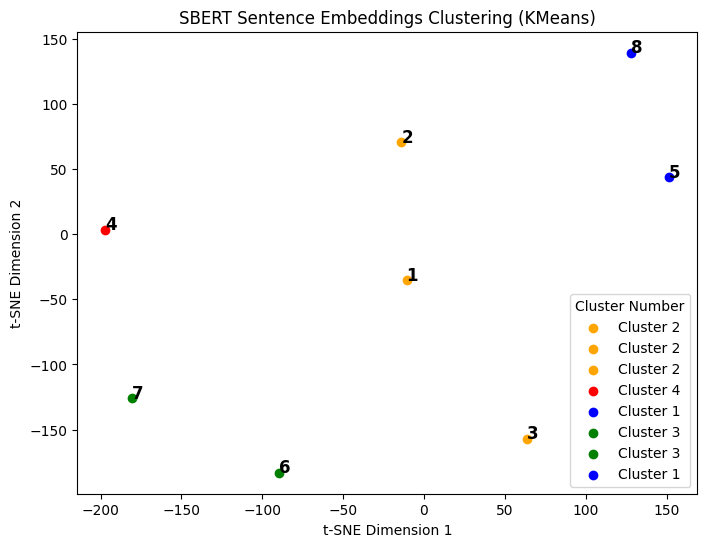


 Cluster-Sentence Mapping:

Cluster 1:
   - Researchers are working on next-generation vaccines to combat evolving viruses.
   - Researchers in a laboratory developing next-generation vaccines to combat evolving viruses.

Cluster 2:
   - Low-income countries rely heavily on international vaccine initiatives for immunization.
   - The cost of vaccine development has been offset by global funding strategies.
   - Gavi has supported immunization programs in over 70 countries, improving access.

Cluster 3:
   - A health worker administers a vaccine to a child in a rural clinic, illustrating Gavi's efforts to improve immunization access in low-income countries.
   - A mother holds her child while receiving a vaccine in a conflict-affected region, highlighting the challenges of vaccine distribution in such areas.

Cluster 4:
   - Political instability affects vaccine distribution in conflict zones.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#  Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(sentence_embeddings) - 1))
reduced_embeddings = tsne.fit_transform(sentence_embeddings)

#  Assign cluster labels (starting from 1)
cluster_labels = kmeans.labels_ + 1  # Renumber clusters to start from 1

#  Plot the clusters
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red']  # Color for each cluster

for i, (x, y) in enumerate(reduced_embeddings):
    cluster_id = cluster_labels[i]
    plt.scatter(x, y, color=colors[cluster_id - 1], label=f"Cluster {cluster_id}" if cluster_id not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.text(x, y, str(i + 1), fontsize=12, weight='bold', color='black')  # Number each sentence

#  Add title and legend
plt.title("SBERT Sentence Embeddings Clustering (KMeans)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster Number")
plt.show()
print("\n Cluster-Sentence Mapping:\n")
cluster_sentence_map = {i + 1: [] for i in range(num_sentences)}

for idx, label in enumerate(labels):
    cluster_sentence_map[label + 1].append(documents[idx])

for cluster, sentences in cluster_sentence_map.items():
    print(f"Cluster {cluster}:")
    for sent in sentences:
        print(f"   - {sent}")
    print()

In [ ]:
#  Print Summary
print("\nGenerated Summary:\n", summary)


Generated Summary:
 Low-income countries rely heavily on international vaccine initiatives for immunization. Political instability affects vaccine distribution in conflict zones. Researchers are working on next-generation vaccines to combat evolving viruses. A health worker administers a vaccine to a child in a rural clinic, illustrating Gavi's efforts to improve immunization access in low-income countries.


In [ ]:
#  Reference Summary
reference_summary = """Low-income countries rely on international vaccine initiatives for immunization.
Gavi has played a major role in improving vaccine accessibility in over 70 countries.
Political instability challenges vaccine distribution in conflict zones.
Researchers are developing next-generation vaccines to combat evolving viruses."""

#  ROUGE Evaluation
def evaluate_summary(reference_summary, generated_summary):
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary, reference_summary)
    return scores

rouge_scores = evaluate_summary(reference_summary, summary)

#  Print ROUGE Scores
print("\nROUGE Scores:")
for metric, score in rouge_scores[0].items():
    print(f"{metric}: Precision={score['p']:.4f}, Recall={score['r']:.4f}, F1-score={score['f']:.4f}")



ROUGE Scores:
rouge-1: Precision=0.6000, Recall=0.6857, F1-score=0.6400
rouge-2: Precision=0.3800, Recall=0.4872, F1-score=0.4270
rouge-l: Precision=0.6000, Recall=0.6857, F1-score=0.6400


In [ ]:
!pip install sentence-transformers


  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Load SBERT model
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Sentences
sentences = [
    "The Expanded Programme on Immunisation was launched by the WHO in 1974.",
    "Smallpox was declared eradicated in 1980 after a successful global vaccination campaign.",
    "The climate crisis is spurring disease outbreaks in vulnerable communities.",
    "The UK is considering a significant cut to its support for global vaccine programs.",
    "Polio remains endemic in just a few countries, but progress is steady."
]

# Generate embeddings
sentence_embeddings = np.array([sbert_model.encode(sent) for sent in sentences])

# Apply KMeans clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(sentence_embeddings)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Compute Euclidean distances of each sentence from its cluster center
euclidean_distances = [
    np.linalg.norm(sentence_embeddings[i] - cluster_centers[cluster_labels[i]])
    for i in range(len(sentences))
]

for i, (sent, cluster, dist) in enumerate(zip(sentences, cluster_labels, euclidean_distances)):
    print(f"Sentence {i+1}: {sent}\n   -> Cluster: {cluster}, Distance to Centroid: {dist:.4f}\n")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence 1: The Expanded Programme on Immunisation was launched by the WHO in 1974.
   -> Cluster: 0, Distance to Centroid: 0.5691

Sentence 2: Smallpox was declared eradicated in 1980 after a successful global vaccination campaign.
   -> Cluster: 0, Distance to Centroid: 0.6219

Sentence 3: The climate crisis is spurring disease outbreaks in vulnerable communities.
   -> Cluster: 1, Distance to Centroid: 0.0000

Sentence 4: The UK is considering a significant cut to its support for global vaccine programs.
   -> Cluster: 0, Distance to Centroid: 0.6330

Sentence 5: Polio remains endemic in just a few countries, but progress is steady.
   -> Cluster: 2, Distance to Centroid: 0.0000

